# Continuous Control Solved Using DDPG

### Udacity Project Submission by Jayanth Nair

This notebook walks through the implementation of the DDPG algorithm to solve the UnityML Reacher environment (with 20 agents running parallely)

In [1]:
# necessary imports to get environment up and running
from unityagents import UnityEnvironment
import numpy as np

In [2]:
# opening the parallel agents exe file
env = UnityEnvironment(file_name='Reacher_Windows_ParallelAgents/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# obtaining brain information
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### DDPG Implementation Details

The hyper-parameters and neural network architecture was determined after a trial and error process.

#### Neural Network Architecture

The actor network consists of 3 fully connected layers.  The input layer consists of 128 units, the hidden layer consists of 64 units and the output layer consists of 4 units corresponding to the action_size parameter.  The ReLU activation function is used for the input and hidden layer. The tanh activation function is used on the output layer -> clips actions between -1 and 1

The critic network also consists of 3 fully connected layers with a similar number of units as the actor network.  However, in the hidden layer, an additional 4 units are connected to link the actions. The activation functions are the same as the actor network.

The weights for the actor and critic network are initialized as per Lillicrap et al. (2016)

#### Agent Hyper-parameters

| Hyper-parameter | Value |
| :-------------- | ----: |
| Replay Buffer Size | 10^6 |
| Batch Size | 512 |
| Discount Factor (Gamma) | 0.99 |
| Soft Update Annealing Factor (Tau) | 0.001 |
| Learning Rate for Actor | 0.0001 |
| Learning Rate for Critic | 0.0001 |
| L2 Weight Decay for Critic Optimizer | 0 |
| Time Steps Before Update | 20 |
| Number of Updates | 10 |

In [5]:
# import modules
import torch
%load_ext autoreload
%aimport ddpg_multiagent # enables reloading the agent class without refreshing kernel
from ddpg_multiagent import Agent
import matplotlib.pyplot as plt
from collections import deque

In [6]:
n_agents=20 # number of agents 

In [7]:
# initializing agent
agent = Agent(state_size=state_size,action_size=action_size,random_seed=0,n_agents=n_agents)

In [11]:
def ddpg_multiagent(n_agents, n_episodes=1000, max_t=1000, print_every=10):
'''
Function which runs the training process 

Arguments:
 n_agents (int) : Number of agents
 n_episodes (int): Max number of episodes to run training
 max_t (int): Max time steps in each episode
 print_every (int): Printing summarized results every x episodes
 
Returns :
 scores (list): List of averaged scores over all agents for each episode 


'''
    scores_deque = deque(maxlen=100)
    scores = []
    best_score = 0.
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        agent_scores = np.zeros(n_agents)
        for t in range(max_t):
            action = [agent.act(state[agent_id], agent_id) for agent_id in range(n_agents)]
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            for agent_id in range(n_agent):
                agent_scores[agent_id] += reward[agent_id]
                agent.step(state[agent_id], action[agent_id], reward[agent_id], 
                           next_state[agent_id], done[agent_id], agent_id)
            state = next_state
            if any(done):
                break
        score = np.mean(agent_scores)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode # - {0},\tAverage Score - {1},\tAverage Score over 100 Episodes-{2}'.format(i_episode, round(score,2), round(np.mean(scores_deque),2)))
        if score > best_score:
            print('\rScore of {0} better than previous best score of {1} - Saving weights!'.format(round(score,2),round(best_score,2)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            best_score = score
        if i_episode % print_every == 0:
            print('\rEpisode # - {0},\tAverage Score - {1},\tAverage Score over 100 Episodes-{2}'.format(i_episode, round(score,2), round(np.mean(scores_deque),2)))
        if score > 30 and np.mean(scores_deque) > 30:
            print('\rReacher environment with {0} agents solved in {1} episodes!'.format(n_agents,i_episode))
            break

    return scores


Episode # - 1,	Average Score - 0.53,	Average Score over 100 Episodes-0.53
Score of 0.53 better than previous best score of 0.0 - Saving weights!
Episode # - 2,	Average Score - 0.68,	Average Score over 100 Episodes-0.6
Score of 0.68 better than previous best score of 0.53 - Saving weights!
Episode # - 3,	Average Score - 0.65,	Average Score over 100 Episodes-0.62
Episode # - 4,	Average Score - 0.5,	Average Score over 100 Episodes-0.59
Episode # - 5,	Average Score - 0.74,	Average Score over 100 Episodes-0.62
Score of 0.74 better than previous best score of 0.68 - Saving weights!
Episode # - 6,	Average Score - 0.95,	Average Score over 100 Episodes-0.68
Score of 0.95 better than previous best score of 0.74 - Saving weights!
Episode # - 7,	Average Score - 0.93,	Average Score over 100 Episodes-0.71
Episode # - 8,	Average Score - 1.05,	Average Score over 100 Episodes-0.75
Score of 1.05 better than previous best score of 0.95 - Saving weights!
Episode # - 9,	Average Score - 0.96,	Average Score 

Episode # - 72,	Average Score - 14.91,	Average Score over 100 Episodes-4.91
Episode # - 73,	Average Score - 15.75,	Average Score over 100 Episodes-5.05
Episode # - 74,	Average Score - 15.4,	Average Score over 100 Episodes-5.19
Episode # - 75,	Average Score - 15.81,	Average Score over 100 Episodes-5.34
Episode # - 76,	Average Score - 18.28,	Average Score over 100 Episodes-5.51
Score of 18.28 better than previous best score of 15.85 - Saving weights!
Episode # - 77,	Average Score - 17.19,	Average Score over 100 Episodes-5.66
Episode # - 78,	Average Score - 19.86,	Average Score over 100 Episodes-5.84
Score of 19.86 better than previous best score of 18.28 - Saving weights!
Episode # - 79,	Average Score - 21.39,	Average Score over 100 Episodes-6.04
Score of 21.39 better than previous best score of 19.86 - Saving weights!
Episode # - 80,	Average Score - 21.36,	Average Score over 100 Episodes-6.23
Episode # - 80,	Average Score - 21.36,	Average Score over 100 Episodes-6.23
Episode # - 81,	Ave

Episode # - 147,	Average Score - 37.45,	Average Score over 100 Episodes-25.72
Episode # - 148,	Average Score - 37.27,	Average Score over 100 Episodes-26.04
Episode # - 149,	Average Score - 37.78,	Average Score over 100 Episodes-26.36
Episode # - 150,	Average Score - 37.22,	Average Score over 100 Episodes-26.68
Episode # - 150,	Average Score - 37.22,	Average Score over 100 Episodes-26.68
Episode # - 151,	Average Score - 37.68,	Average Score over 100 Episodes-27.0
Episode # - 152,	Average Score - 37.76,	Average Score over 100 Episodes-27.31
Episode # - 153,	Average Score - 37.71,	Average Score over 100 Episodes-27.62
Episode # - 154,	Average Score - 37.58,	Average Score over 100 Episodes-27.92
Episode # - 155,	Average Score - 37.15,	Average Score over 100 Episodes-28.21
Episode # - 156,	Average Score - 37.47,	Average Score over 100 Episodes-28.51
Episode # - 157,	Average Score - 37.81,	Average Score over 100 Episodes-28.81
Episode # - 158,	Average Score - 37.4,	Average Score over 100 Epi

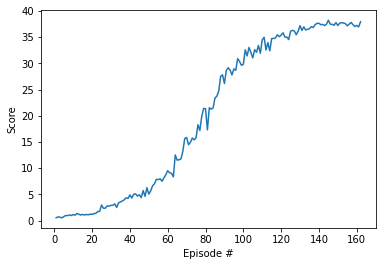

In [12]:
scores = ddpg_multiagent(n_agents)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()